In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from src.numpy_encode import *
from src.utils.file_processing import process_all, process_file
from src.config import *
from src.music_transformer import *

## Example notebook explaining how to encode midi to numpy array and train with fastai

Numpy format 

In [4]:
data_path = Path('data')

# Location of your midi files
midi_path = data_path/'midi'
midi_path.mkdir(parents=True, exist_ok=True)

# Location of transformed midi to numpy dataset
numpy_path = data_path/'numpy'/'combined_tracks'
numpy_path.mkdir(parents=True, exist_ok=True)

data_save_name = 'data_idxenc.pkl'

## 1. Gather midi dataset

Make sure all your midi data is in `musicautobot/data/midi` directory

Here's a pretty good dataset with lots of midi data:  
https://www.reddit.com/r/datasets/comments/3akhxy/the_largest_midi_collection_on_the_internet/

Download the folder and unzip it to `data/midi`

### 2. Encode midi files to numpy

For more in customized encoding - see `notebooks/dataformatting/2-DataFormatting-AllCombined-X.ipynb`

In [5]:
midi_files = get_files(midi_path, '.mid', recurse=True); len(midi_files)

18

In [6]:
def transform_midi(midi_file):
    try:
        npenc = midi2npenc(midi_file)
    except Exception as e:
        print('Could not encode to file:', midi_file, e)
        return None
    
    if not is_valid_npenc(npenc, input_path=midi_file):
        return None
    
    return npenc

In [7]:
process_func = partial(process_file, tfm_func=transform_midi, src_path=midi_path, dest_path=numpy_path)
processed = process_all(process_func, midi_files, timeout=50, timeout_func=None)

## Library

In [8]:
from src.vocab import MusicVocab

## 3. Create dataset from encoded files

In [9]:
numpy_files = get_files(numpy_path, '.npy', recurse=True); len(numpy_files)

18

In [10]:
processors = [OpenNPFileProcessor(), MusicItemProcessor()]

data = MusicDataBunch.from_folder(numpy_path, processors=processors)
data.save(data_save_name)

In [11]:
data.one_batch()

(tensor([[ 73, 139,   8,  ..., 139,  73, 139],
         [ 73, 139,   8,  ..., 139,  73, 139],
         [ 73, 139,   8,  ..., 139,  73, 139],
         ...,
         [ 73, 139,   8,  ..., 139,  73, 139],
         [ 73, 139,   8,  ..., 139,  73, 139],
         [ 73, 139,   8,  ..., 139,  73, 139]]),
 tensor([[139,   8, 139,  ...,  73, 139,   8],
         [139,   8, 139,  ...,  73, 139,   8],
         [139,   8, 139,  ...,  73, 139,   8],
         ...,
         [139,   8, 139,  ...,  73, 139,   8],
         [139,   8, 139,  ...,  73, 139,   8],
         [139,   8, 139,  ...,  73, 139,   8]]))

In [12]:
# Check number of files
len(data.train_dl.dl.x), len(data.valid_dl.dl.x)

(17, 1)

In [13]:
type(data.valid_dl.dataset.x)

src.music_transformer.dataloader.MusicItemList

In [14]:
data.valid_dl.dataset.x.items[0].shape

(2, 134)

In [15]:
a = data.valid_dl.dataset.x[0]

In [16]:
data.train_dl.dataset.x.items[0]

array([array([  0,   1,  64, 153, ...,   8, 139,  69, 139]),
       array([   0,    0,    0,    0, ..., -124, -124, -126, -126])], dtype=object)

In [17]:
b = data.train_dl.dataset.x[0]

In [18]:
a.data

array([  0,   1,  66, 139, ...,   8, 139,  76, 145])

In [19]:
b.data

array([  0,   1,  64, 153, ...,   8, 139,  69, 139])

## 4. Load Model

In [20]:
batch_size = 1
data = load_data(numpy_path, data_save_name, bs=batch_size)

In [21]:
# config = tfmerXL_lm_config.copy(); config

In [22]:
config = default_config(); config

{'ctx_len': 150,
 'n_layers': 16,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'transpose_range': (0, 12),
 'bs': 16,
 'bptt': 256}

In [23]:
learn = music_model_learner(data, config.copy())

In [24]:
type(learn.data.valid_dl.dataset.x)

src.music_transformer.dataloader.MusicItemList

In [25]:
learn.data.valid_dl.dataset.x[0]

xxbos xxpad n57 d2 n52 d16 n48 d16 n45 d16 xxsep d2 n59 d2 xxsep d2 n60 d2 xxsep d2 n62 d2 xxsep d2 n64 d2 xxsep d2 n60 d2 xxsep d2 n64 d4 xxsep d4 n63 d2 n54 d8 n51 d8 n47 d8 xxsep d2 n59 d2 xxsep d2 n63 d4 xxsep d4 n62 d2 n53 d8 n50 d8 n46 d8 xxsep d2 n58 d2 xxsep d2 n62 d4 xxsep d4 n57 d2 n52 d16 n48 d16 n45 d16 xxsep d2 n59 d2 xxsep d2 n60 d2 xxsep d2 n62 d2 xxsep d2 n64 d2 xxsep d2 n60 d2 xxsep d2 n64 d2 xxsep d2 n69 d2 xxsep d2 n67 d2 n55 d16 n52 d16 n48 d16 xxsep d2 n64 d2 xxsep d2 n60 d2 xxsep d2 n64 d2 xxsep d2 n67 d8

In [26]:
learn.validate()

[6.710268, tensor(0.)]

In [27]:
# model = get_language_model(TransformerXL, len(vocab.itos), config=config)
# learn = MusicLearner(data, model, split_func=tfmerXL_lm_split)

In [28]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,3.457739,2.798141,0.228571,00:07
1,2.849066,2.727003,0.500000,00:06
2,2.758343,2.338222,0.500000,00:07
3,2.711816,2.504394,0.500000,00:06


## 5. Prediction time

In [17]:
midi_files = get_files(data_path, '.mid', recurse=True)
midi_file = midi_files[0]; midi_file

PosixPath('data/midi/examples/Levels - Avicii - Verse.mid')

In [18]:
item = MusicItem.from_file(midi_file, vocab); item.data

array([  0,   1,  85, 143, ...,   8, 139,  66, 141])

Only send a few notes 

In [38]:
seed_len = 4
seed_item = item.trim_to_beat(seed_len)

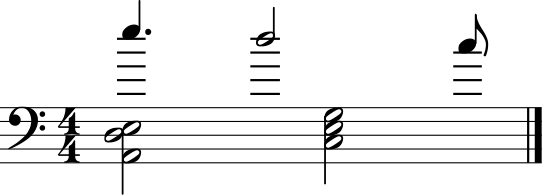

In [39]:
seed_item.show_score()

Here's what the seed sounds like:

In [40]:
seed_item.show_midi()

### Start Predictions:

In [41]:
seed_item.data.shape

(28,)

In [42]:
seed_item.to_tensor()

tensor([  0,   1,  85, 143,  61, 145,  59, 145,  54, 145,   8, 143,  83, 145,
          8, 139,  64, 145,  61, 145,  57, 145,   8, 143,  81, 139,   8, 139],
       device='cuda:0')

In [43]:
out = learn.predict(seed_item.to_tensor(), n_words=100)

Seed - used for prediction

Prediction

In [44]:
out

array([ 67, 139,  67, 153, ...,   8, 139,   8, 139])

Non midi note detected. Only returning valid portion. Index, seed 8 (50, 2)


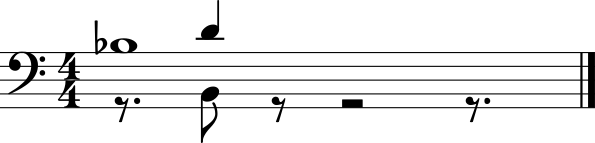

In [45]:
# Prediction
stream = vocab.musicify(out)
stream.show_score()

In [47]:
stream.show_midi()